# บทที่ 4t (3/3) - ข้อมูลอนุกรมเวลา - Time-series data

อ.ดร.ธนชาตย์ ฤทธิ์บำรุง (อ.เชค)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/04t_03_time_series.ipynb)

**เป้าหมายการเรียนรู้**
1. เข้าใจถึงองค์ประกอบของข้อมูลประเภทอนุกรมเวลา
2. สร้าง Forecasting Model เพื่อใช้ทำนายข้อมูลในอนาคตได้

*   ข้อมูลอนุกรมเวลา หรือ time-series data เป็นข้อมูลประเภทที่มีเวลากำกับอยู่
*   ข้อมูลในการทำการวิเคราะห์ส่วนมากจะถูกจัดเก็บอยู่ในรูปแบบของอนุกรมเวลา
*   การวิเคราะห์ที่นิยมมากสำหรับข้อมูลอนุกรมเวลา คือ การพยากรณ์ค่าในอนาคต
*   สิ่งที่นิยมพยากรณ์กันในธุรกิจ คือ การพยากรณ์ยอดขาย
*   ในข้อมูลอนุกรมเวลานั้น ประกอบด้วย 4 องค์ประกอบ
*   Trend เป็นส่วนที่แสดงถึงทิศทางการเปลี่ยนแปลง
*   Seasonal เป็นส่วนที่แสดงถึงการเปลี่ยนแปลงที่เป็นรูปแบบเดิมในช่วงสั้น
*   Cyclical เป็นส่วนที่แสดงถึงการเปลี่ยนแปลงที่เป็นรูปแบบเดิมในช่วงระยะยาว (มากกว่า 1 ปี)
*   Irregular เป็นส่วนที่เกิดขึ้นแบบสุ่ม คาดการณ์หรือพยากรณ์ไม่ได้

<img src=https://github.com/ai-builders/curriculum/raw/main/images/tabular_images/24.png width="1000px">

# Prophet Module

ในการวิเคราะห์ข้อมูลอนุกรมเวลา หรือ การพยากรณ์ข้อมูลนั้น เราจะใช้ Prophet Module ที่ถูกพัฒนาขึ้นโดย Facebook

In [9]:
# Load module ที่เราต้องการใช้ทั้งหมด

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [10]:
# อ่านไฟล์ข้อมูลที่ต้องการวิเคราะห์

url = 'https://github.com/ai-builders/curriculum/raw/main/data/bangkok-air-quality.csv'
df = pd.read_csv(url)

In [11]:
# แสดงผลตัวอย่างข้อมูล

df.head(5)

,date,pm25,pm10,o3,no2,so2,co
0,2022/2/1,68,31,9,4,,
1,2022/2/2,58,35,10,6,,
2,2022/2/3,66,37,15,11,,
3,2022/2/4,73,48,17,15,1,
4,2022/2/5,94,54,21,13,1,


In [12]:
# ตรวจสอบ data types จะพบว่า คอลัมน์ date ถูกมองว่าเป็น string หรือ text

df.dtypes

date     object
 pm25    object
 pm10    object
 o3      object
 no2     object
 so2     object
 co      object
dtype: object

In [13]:
# อ่านไฟล์ข้อมูลใหม่ โดยระบุชื่อคอลัมน์ที่มีประเภทข้อมูลเป็น date

df = pd.read_csv(url, parse_dates=['date'])

In [14]:
# ตรวจสอบ data types จะพบว่า คอลัมน์ date ถูกมองว่า date-time ถูกต้อง แต่ คอลัมภ์ pm25 ยังถูกมองเป็น string อยู่

df.dtypes

date     datetime64[ns]
 pm25            object
 pm10            object
 o3              object
 no2             object
 so2             object
 co              object
dtype: object

In [15]:
# แปลงประเภทข้อมูลของคอลัมภ์ pm25 ให้เป็น numeric

df['pm25'] = pd.to_numeric(df[' pm25'], errors='coerce')

In [16]:
# สร้าง dataframe ใหม่ ให้มีเฉพาะคอลัมน์ที่ต้องการ คือ คอลัมน์เวลา และค่าที่เราต้องการพยากรณ์

df_pm25 = df[['date', 'pm25']]

<Axes: title={'center': 'PM2.5 Concentration'}, xlabel='date'>

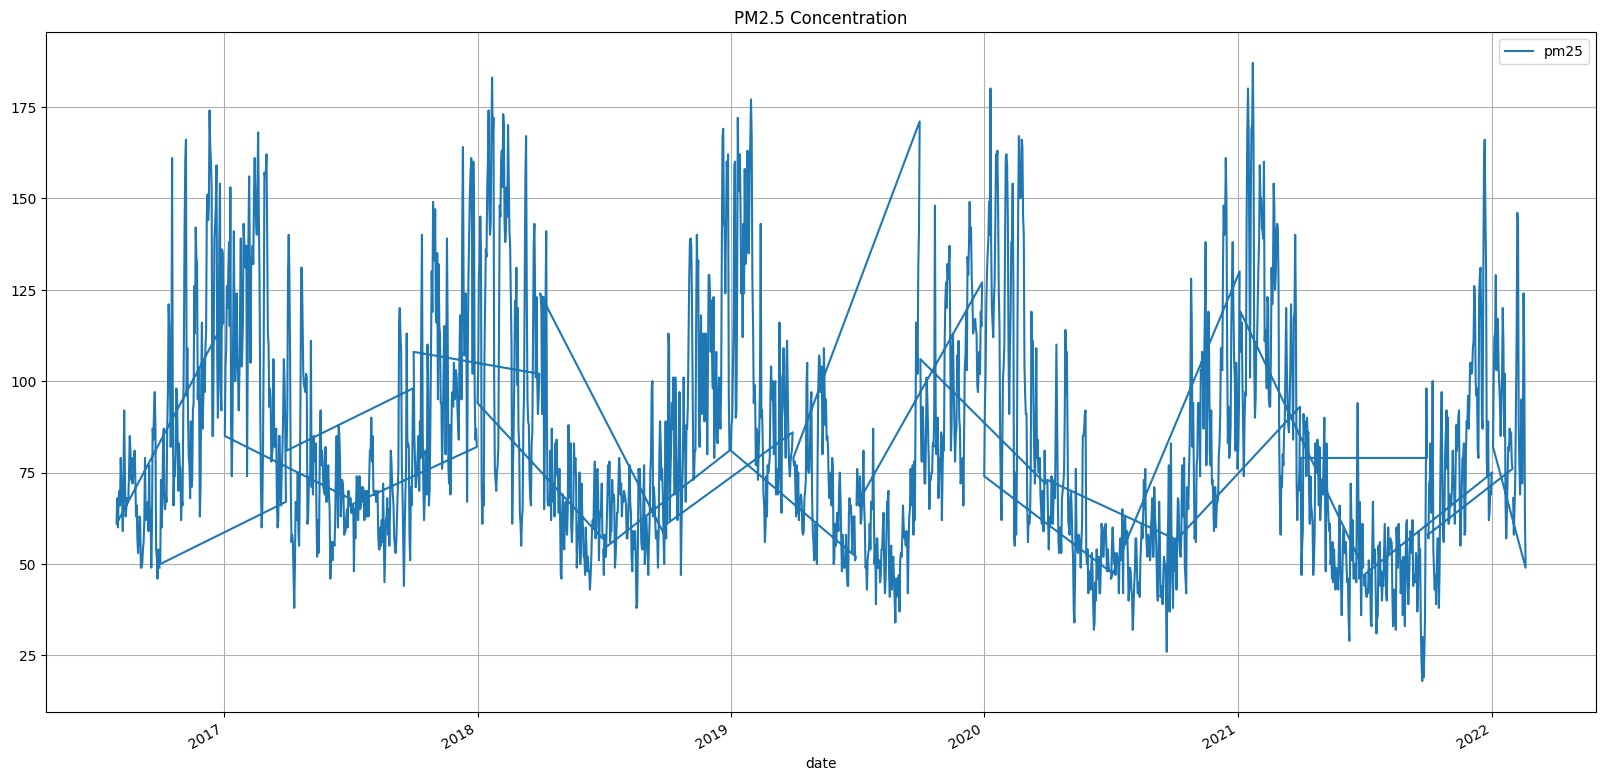

In [17]:
# plot graph

df_pm25.set_index("date").plot(title='PM2.5 Concentration', grid=True, figsize=(20,10))

In [18]:
# ใน prophet จะอ่านจากชื่อคอลัมน์ว่า อันไหนเป็น เวลา อันไหนเป็น ค่าที่ต้องพยากรณ์ โดยต้องตั้ง ให้เป็นชื่อว่า ds และ y ตามลำดับ

df_pm25 = df_pm25.rename(columns={'date': 'ds', 'pm25': 'y'})

df_pm25.tail()

,ds,y
2961,2015-03-15,NaN
2962,2014-11-30,NaN
2963,2013-12-31,NaN
2964,2014-01-26,NaN
2965,2016-01-01,NaN


In [19]:
# หาวันสุดท้ายที่มีข้อมูลใน data ของเรา

df_pm25['ds'].max()

Timestamp('2022-02-19 00:00:00')

In [20]:
# สร้าง model สำหรับการทำนาย

my_model = Prophet(interval_width=0.95)

In [21]:
# train model จากข้อมูลเก่า

my_model.fit(df_pm25)

07:10:19 - cmdstanpy - INFO - Chain [1] start processing
07:10:19 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# สร้าง dataframe สำหรับวันในอดีตและอนาคตที่ต้องการทำนาย

future_dates = my_model.make_future_dataframe(periods=7)
future_dates.tail(7)

,ds
2966,2022-02-20
2967,2022-02-21
2968,2022-02-22
2969,2022-02-23
2970,2022-02-24
2971,2022-02-25
2972,2022-02-26


In [23]:
# พยากรณ์ข้อมูล

forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2968,2022-02-22,92.217778,51.444431,130.574833
2969,2022-02-23,91.280434,49.937684,130.998669
2970,2022-02-24,89.004797,50.220880,131.277503
2971,2022-02-25,87.137100,46.280743,126.748991
2972,2022-02-26,86.427654,48.254665,126.594134


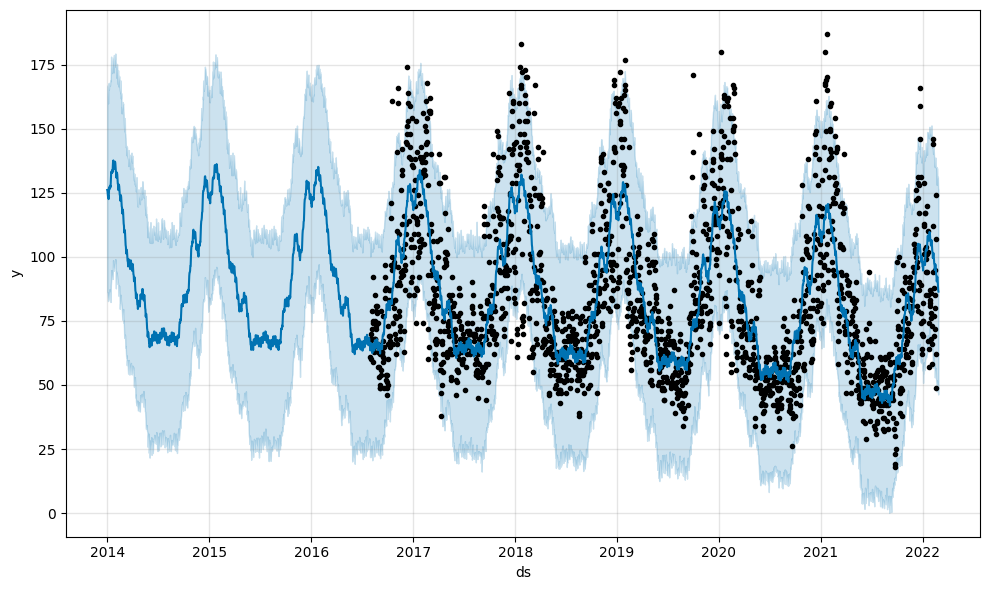

In [24]:
# แสดงผลการพยากรณ์

fig1 = my_model.plot(forecast)

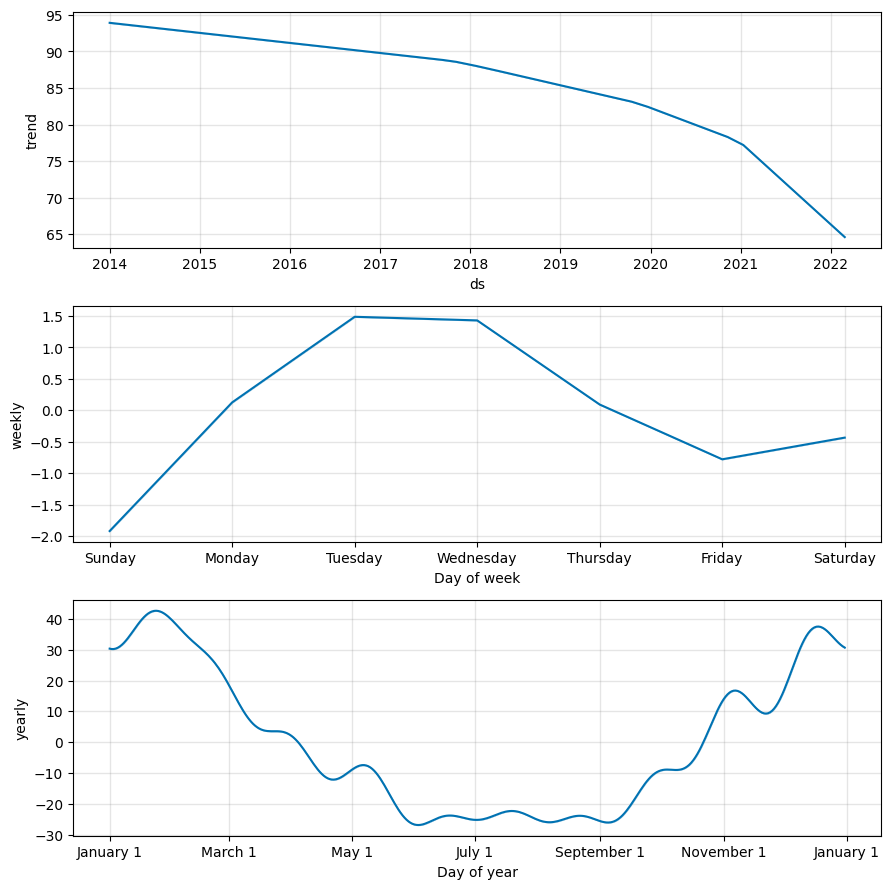

In [25]:
# แสดงผลองค์ประกอบ trend และ seasonal pattern

fig2 = my_model.plot_components(forecast)

In [26]:
# รวมค่าจริงและค่าพยากรณ์เพื่อนำไปคำนวณหาค่าความแม่นยำ

df_merge = pd.merge(df_pm25, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2022-02-01,63.382539,151.307990,106.557375,68.0
1,2022-02-02,65.409265,145.089994,105.802069,58.0
2,2022-02-03,64.671152,143.929323,103.742395,66.0
3,2022-02-04,64.639906,142.635269,102.136129,73.0
4,2022-02-05,62.037519,144.410760,101.741879,94.0


# Cross Validation

In [28]:
# ทำการ cross validation การทำนายผล

from prophet.diagnostics import cross_validation

df_cv = cross_validation(my_model, initial='1820 days', period='10 days', horizon = '10 days')

  0%|          | 0/21 [00:00<?, ?it/s]07:15:08 - cmdstanpy - INFO - Chain [1] start processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 1/21 [00:00<00:03,  5.50it/s]07:15:08 - cmdstanpy - INFO - Chain [1] start processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 2/21 [00:00<00:03,  5.35it/s]07:15:08 - cmdstanpy - INFO - Chain [1] start processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 3/21 [00:00<00:03,  5.49it/s]07:15:08 - cmdstanpy - INFO - Chain [1] start processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 4/21 [00:00<00:03,  5.43it/s]07:15:08 - cmdstanpy - INFO - Chain [1] start processing
07:15:08 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 5/21 [00:00<00:03,  4.82it/s]07:15:09 - cmdstanpy - INFO - Chain [1] start processing
07:15:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 6/21 [00:01<00:03,  4.59it/s]07:15:09

In [29]:
# แสดงผลการ cross validation

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-07-25,51.000369,8.387765,91.128584,44.0,2021-07-24
1,2021-07-26,52.603108,11.969654,95.721468,48.0,2021-07-24
2,2021-07-27,53.400066,10.188390,95.047767,40.0,2021-07-24
3,2021-07-28,53.171267,12.769145,90.727770,45.0,2021-07-24
4,2021-07-29,51.539344,9.126307,94.116476,44.0,2021-07-24


In [30]:
# คำนวณหาค่าความแม่นยำ

from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,604.590282,24.588418,19.166522,0.362945,0.243609,0.266794,0.857143
1,2 days,603.956124,24.575519,19.550308,0.322362,0.317749,0.260611,0.904762
2,3 days,561.978322,23.706082,19.428842,0.389149,0.229071,0.283846,0.857143
3,4 days,400.489004,20.012221,14.775910,0.260246,0.159114,0.205055,0.952381
4,5 days,378.511502,19.455372,16.196555,0.258270,0.171349,0.218606,1.000000


/home/drasogun/.venvs/vol3/lib/python3.13/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/drasogun/.venvs/vol3/lib/python3.13/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


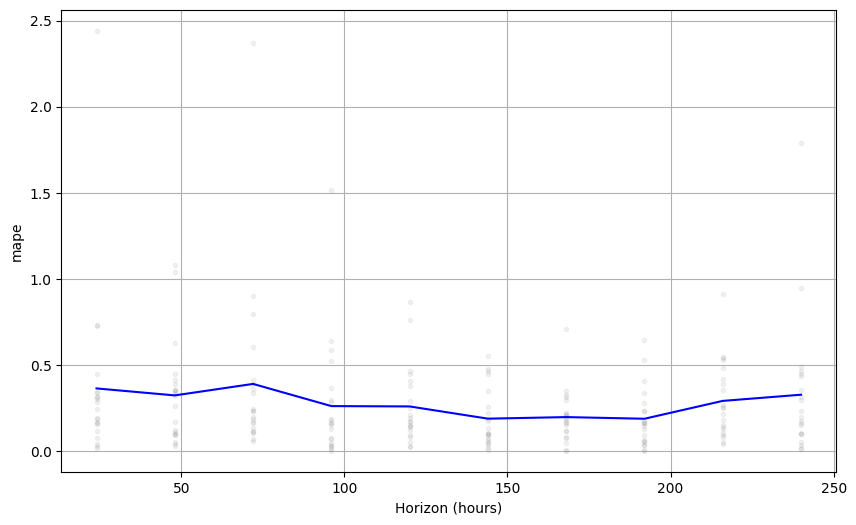

In [31]:
# แสดงผลความแม่นยำ

from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

# Tuning Prophet Model

ในการสร้าง Prophet Model นั้น เราสามารถปรับแต่งค่า parameter ต่างๆ รวมถึงเพิ่ม regressor เข้าไปใน Model เพื่อช่วยในการทำนาย

## Trend - Parameter Tuning

หากเรามีข้อมูลอนุกรมเวลายาว อาจเป็นไปได้ว่ามีการเปลี่ยนแปลง Trend ในช่วงเวลา เช่น บางช่วง Trend เติบโตมาก บางช่วงเป็น Trend ขาลง

เราจะทำการปรับค่า changepoint_prior_scale เพื่อให้ Prophet สามารถตรวจพบการเปลี่ยนแปลงที่เกิดขึ้นได้ด้วยตัวเอง

ยิ่งใส่ค่า changepoint_prior_scale มากขึ้น จะยิ่งตรวจพบการเปลี่ยนแปลงมากขึ้น

07:18:27 - cmdstanpy - INFO - Chain [1] start processing
07:18:27 - cmdstanpy - INFO - Chain [1] done processing


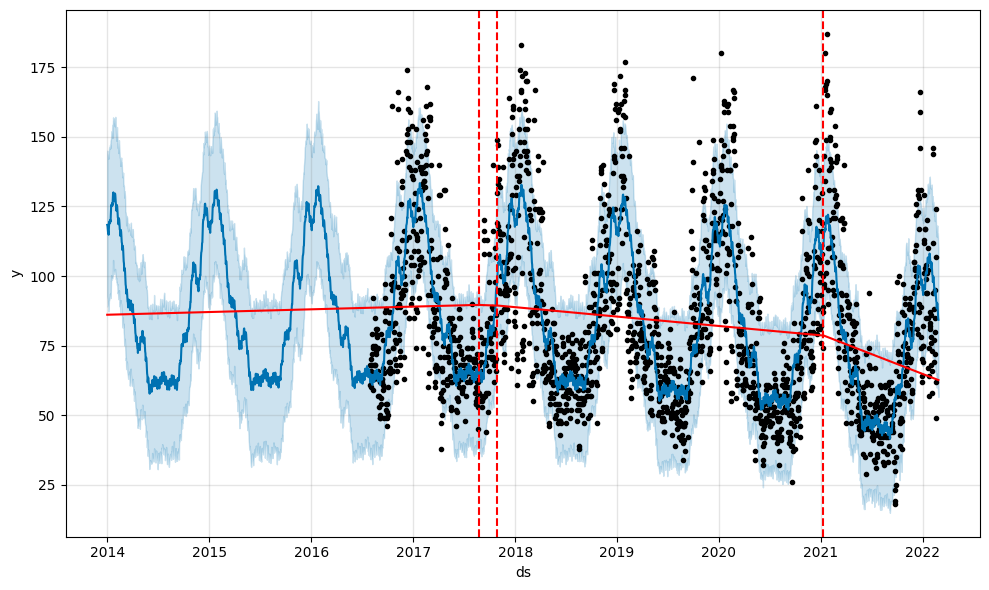

In [32]:
# set changepoint_prior_scale=0.1

my_model_trend_change = Prophet(changepoint_prior_scale=0.1)
my_model_trend_change.fit(df_pm25)
forecast = my_model_trend_change.predict(future_dates)
fig1 = my_model_trend_change.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), my_model_trend_change, forecast)

07:18:28 - cmdstanpy - INFO - Chain [1] start processing
07:18:29 - cmdstanpy - INFO - Chain [1] done processing


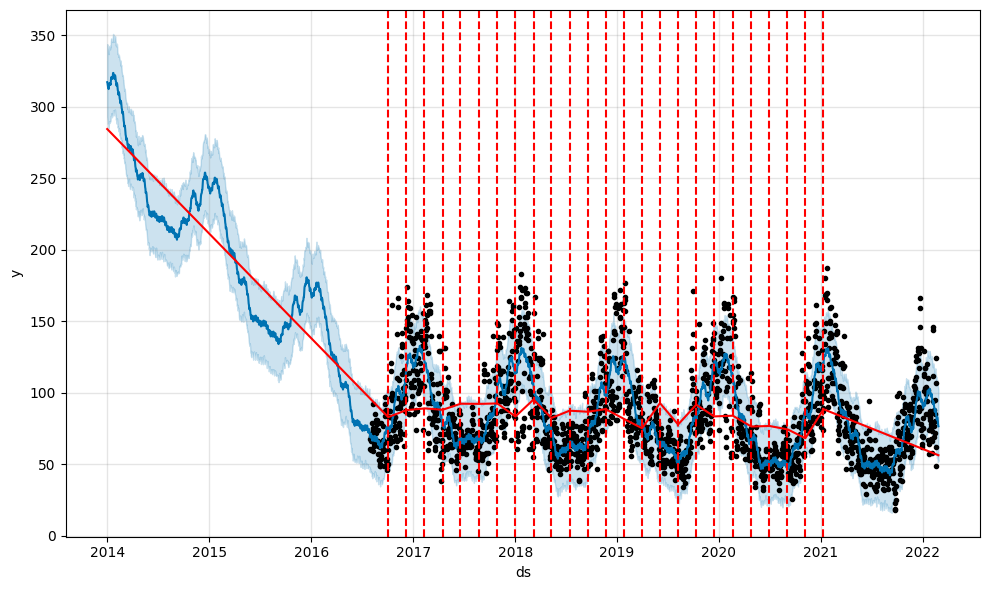

In [33]:
# set changepoint_prior_scale=10

my_model_trend_change = Prophet(changepoint_prior_scale=10)
my_model_trend_change.fit(df_pm25)
forecast = my_model_trend_change.predict(future_dates)
fig1 = my_model_trend_change.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), my_model_trend_change, forecast)

## Seasonal - Parameter Tuning

นอกเหนือจากการเปลี่ยนแปลง Trend แล้ว อาจมีการเปลี่ยนแปลงของ Seasonal ได้ด้วย

เราจะทำการปรับค่า seasonality_prior_scale เพื่อให้ Prophet สามารถตรวจพบการเปลี่ยนแปลงที่เกิดขึ้นได้ด้วยตัวเอง

ยิ่งใส่ค่า seasonality_prior_scale มากขึ้น จะยิ่งตรวจพบการเปลี่ยนแปลงมากขึ้น

07:18:32 - cmdstanpy - INFO - Chain [1] start processing
07:18:32 - cmdstanpy - INFO - Chain [1] done processing


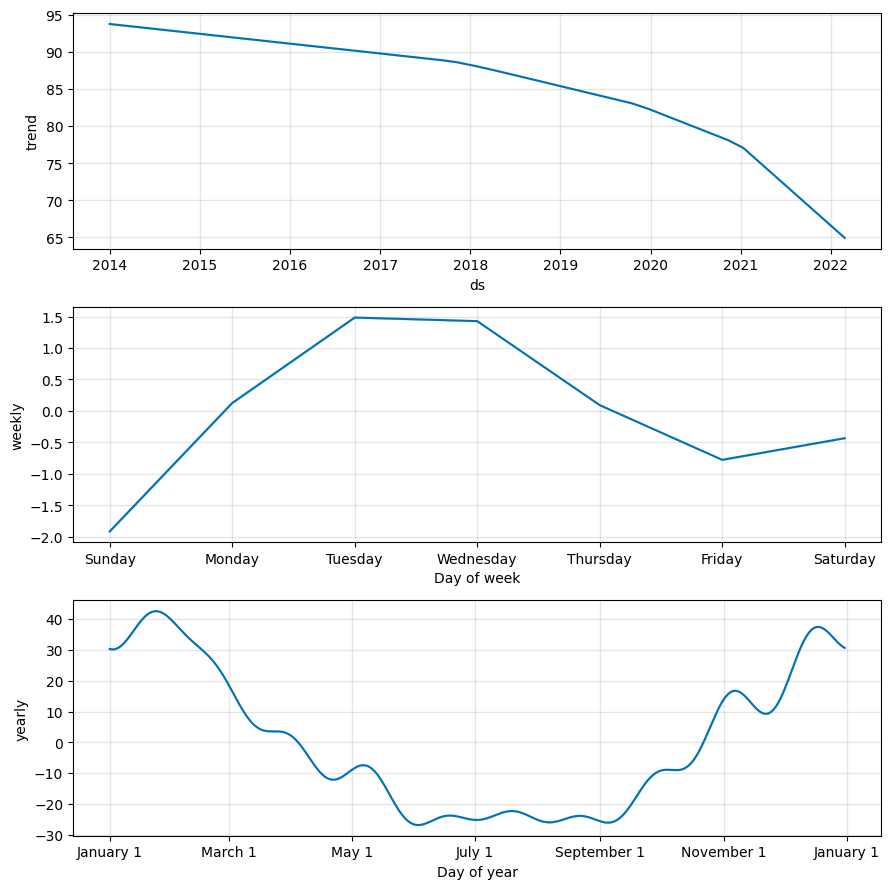

In [34]:
# set seasonality_prior_scale=0.1

my_model_seasonal_change = Prophet(seasonality_prior_scale=0.1)
my_model_seasonal_change.fit(df_pm25)
forecast = my_model_seasonal_change.predict(future_dates)
fig1 = my_model_seasonal_change.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


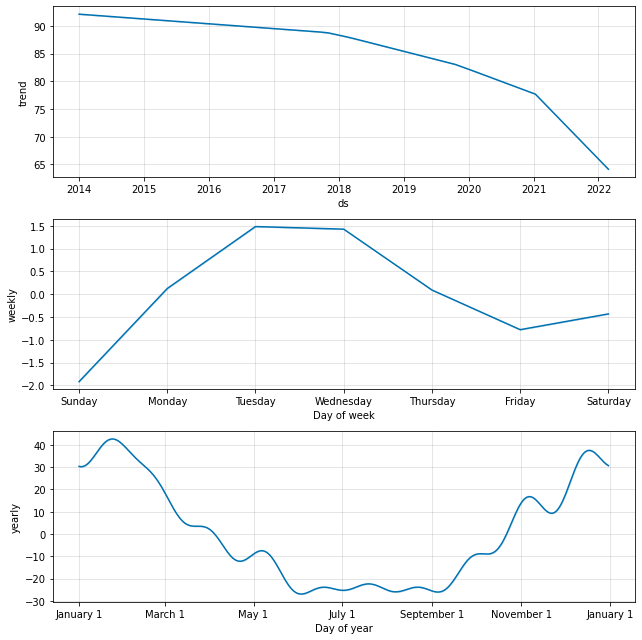

In [ ]:
# set seasonality_prior_scale=10

my_model_seasonal_change = Prophet(seasonality_prior_scale=10)
my_model_seasonal_change.fit(df_pm25)
forecast = my_model_seasonal_change.predict(future_dates)
fig1 = my_model_seasonal_change.plot_components(forecast)

# สร้าง Pipeline เพื่อทำ hyperparameter tuning

In [35]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.1, 1, 5],
    'seasonality_prior_scale': [0.1, 1, 5],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_pm25)  # Fit model with given params
    df_cv = cross_validation(m, initial='1820 days', period='10 days', horizon = '10 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

07:19:34 - cmdstanpy - INFO - Chain [1] start processing
07:19:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/21 [00:00<?, ?it/s]07:19:34 - cmdstanpy - INFO - Chain [1] start processing
07:19:34 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 1/21 [00:00<00:04,  4.64it/s]07:19:34 - cmdstanpy - INFO - Chain [1] start processing
07:19:35 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 2/21 [00:00<00:04,  4.15it/s]07:19:35 - cmdstanpy - INFO - Chain [1] start processing
07:19:35 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 3/21 [00:00<00:04,  4.22it/s]07:19:35 - cmdstanpy - INFO - Chain [1] start processing
07:19:35 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 4/21 [00:00<00:04,  4.16it/s]07:19:35 - cmdstanpy - INFO - Chain [1] start processing
07:19:35 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 5/21 [00:01<00:03,  4.32it/s]07:19:35 - cmdstanpy - INFO - Chain [1] start processi

   changepoint_prior_scale  seasonality_prior_scale      mape
0                      0.1                      0.1  0.275885
1                      0.1                      1.0  0.275929
2                      0.1                      5.0  0.275856
3                      1.0                      0.1  0.264479
4                      1.0                      1.0  0.264564
5                      1.0                      5.0  0.264083
6                      5.0                      0.1  0.259014
7                      5.0                      1.0  0.260065
8                      5.0                      5.0  0.260477


# Save และ Load Model

In [36]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [37]:
with open('prophet_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

# Checkpoint ท้ายบท

*   ☑️เข้าใจถึงองค์ประกอบของข้อมูลประเภทอนุกรมเวลา
*   ☑️สร้าง Forecasting Model เพื่อใช้ทำนายข้อมูลในอนาคตได้